# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Прикладные задачи анализа данных" </center>

# <center>Лабораторная работа №1. NLP</center>

В рамках данной лабораторной работы вам предлагается принять участие в Inclass соревновании на [kaggle](https://www.kaggle.com), в рамках которого необходимо построить модель, которая по тексту комментария определяет его "токсичность".

## Данные

Данные представляют из себя тексты комментариев из Википедии на английском языке.  
Сами тексты представлены в столбце **comment_text**.  
У каждого комментария также есть уникальный идентификатор - **id**.

Для каждого комментария известно, обладает ли он токсичностью определенного типа.  
Всего есть 6 типов токсичности: toxic, severe_toxic, obscene, threat, insult, identity_hate.  
  
Каждый из них представлен отдельным столбцом в обучающей выборке со значениями:  
* `0` - комментарий не обладает данным типом токсичности  
* `1` - обладает.  
  
Комментарий может одновременно обладать несколькими типами токсичности (а может не обладать ни одним). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score

from matplotlib import style
style.use('seaborn')

## Задание

### Соревнование

Инвайт на участие в соревновании: https://www.kaggle.com/t/604ebef4a0d14cc1983005f1a2950bc1.  
Чтобы принять участие, вам необходимо создать аккаунт на kaggle.

В рамках соревнования на kaggle вам необходимо решить задачу **multilabel** классификации: для каждого комментария и для каждого типа токсичности необходимо определить вероятность того, что данный комментарий обладает этим типом токсичности. 

Метрикой качества (точности) решения в данном соревновании является **ROC AUC**, усредненная по типам токстичноcти. 

Для того, чтобы попасть в Leaderscore, нужно создать файл с прогнозами для тестовой выборки (как в `sample_submission.csv`) и выполнить сабмит. В сутки можно сделать до 10 сабмитов. 

<br>  
**NB:** Обратите внимание, что текущий рейтинг (до конца соревнования) строится только на части данных. После окончания соревнования рейтинг будет пересчитан на всех данных и позиции могут измениться.  
Вы можете сами выбрать **три** модели (сабмита), которые будут провалидированы на всех данных. По умолчанию будут выбраны три модели, давшие лучший результат в текущем рейтинге. 

<br>  
### Оценивание

При выполнении лабораторной и создании моделей для классификации вам неоходимо использовать следующие техники, рассмотренные в рамках курса (но не нужно ограничиваться только ими). За использование каждой выставляется определенный балл. 

**Note 1:** Все техники не должны обязательно использоваться в одном решении/модели. Вы можете, например, в одной моделе использовать векторизацию и LSA, а в другой эмбединги. 

**Note 2:** Итоговое количество баллов зависит от того, насколько хорошо вы используете технику. Например, просто взять готовые эмбединги будет оценено ниже, чем обучение своих и/или сравнение различных обученных.

**Техники и баллы:**  
  
* Приведение слов к начальной форме (лемматизация/стемминг) - 1 балл
* Определение и удаление лишних символов и слов - 2 балла
* Векторизация текстов (tf-idf or others) - 1 балл
* LSA/LDA - 2 балла
* Embeddings (word2vec or others) - 2 балла

**Баллы за место в (итоговом) рейтинге:**  
  
* 1 - 7: 4 балла
* 8 - 15: 3 балла
* 16 - 30: 2 балла
* 31 - 50: 1 балл
* Ниже 50 : 0 баллов  
  
**NB:** По ходу лабораторной в соревновании могу появиться baselines, которые необходимо перешагнуть, чтобы получить определенное количество баллов (т.е. просто места в рейтинге не достаточно). 

**Баллы за kernels:**  
  
* Вы можете получить дополнительные баллы, если сделаете и выложите kernel.  
* За каждый kernel можно получить до 2-х баллов (зависит от качества и темы).
* Возможные темы для kernels: EDA, Topic Modeling, Embeddings, сравнение моделей и т.д.


**Gradeback:**  
  
Если итоговая оценка за лабораторную окажется выше 10 баллов, лишние баллы пойдут в бонус как 0.2 за каждый лишний балл. Но не забывайте, что бонус также ограничен 1 баллом.

## Подготовка данных

In [3]:
train = pd.read_csv("Lab_1/data/train.csv")
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,"Gaelic translation \n\nHi, don't suppose you c...",0,0,0,0,0,0
1,1,Hey dick \nYou don't know what is copyright so...,1,0,1,0,1,0
2,2,"""\n\nAm I correct in thinking that you are ref...",0,0,0,0,0,0
3,3,== Notable Alumni == \n\n Why was this section...,0,0,0,0,0,0
4,4,I have already been sent this message about va...,1,0,1,0,1,0
5,5,== exuse me == \n\n i was not attacking someon...,0,0,0,0,0,0
6,6,":You're welcome, Vernon39! Thanks for your imp...",0,0,0,0,0,0
7,7,"Good point by JonC , legally the name of the s...",0,0,0,0,0,0
8,8,"""\nNo such """"compromise"""" was reached on Septe...",0,0,0,0,0,0
9,9,":::Again, we can't take the unverifiable claim...",0,0,0,0,0,0


In [4]:
train.shape

(150000, 8)

In [5]:
test = pd.read_csv("Lab_1/data/test.csv")
test.head(10)

,id,comment_text
0,150000,Dmacks consitatnly edits other peoples pages a...
1,150001,== Contested deletion == \n\n This article sho...
2,150002,March 2008\n Please stop. If you continue to v...
3,150003,"""}\n\nAugust Esperanza Newsletter\n{| style=""""..."
4,150004,"William Sledd\n\nOK, it is time We Tubers had ..."
5,150005,"""\n\n Please apologize: you made a clear mista..."
6,150006,What makes and egg crack? \n FORCE!!!!!!!!! \n...
7,150007,""" \n :::::No, your comparison is invalid. Your..."
8,150008,"The Tree in a Test Tube, 1942 (full).ogv|The T..."
9,150009,:::I should have listened to your advice. Alan...


In [6]:
test.shape

(50000, 2)

Посмотрим на распределение типов токсичности. Как видно из графика, комментарии распределены по типам неравномерно, что стоит учитывать при обучении

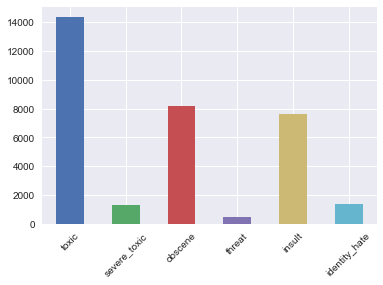

In [7]:
train.iloc[:, 2:].sum().plot(kind='bar', rot=45)

In [7]:
for i in train['comment_text'].values[:100]:
    print(i)
    print("-------------------------------")

Gaelic translation 

Hi, don't suppose you could help me out with a Gaelic translation for ? Thanks in advance if you're able to -
-------------------------------
Hey dick 
You don't know what is copyright so shutup and get out of here, don't write stupid bullshit on my talk page. Dhivehi language is Dhivehi language not your bullshit nonsese.
-------------------------------
"

Am I correct in thinking that you are referring to the ""shattering of the vessels"", first discussed by the Arizal? There is a mention of it there . It might be possible to expand on that.   "
-------------------------------
== Notable Alumni == 

 Why was this section all-but-deleted? US has many notable allumni, but currently the only one listed is a teacher who just happened to pitch for the Detroit Tigers a long, long time ago (in a galaxy far, far away?). For one, his son Michael Seelbach currently has a lead role in the Chicago production of Wicked. I understand that it was often vandalized by students of

Из текста можно удалить 
* цифры
* сокращения стран 
* IP - удалится вместе с цифрами и знаками препинания
* ссылки
* названия файлов с расширениями
* вставки(в квадратных скобках)
* темы(начинаются с ==)
* даты и время - удалятся вместе с цифрами и знаками препинания
* иероглифы 
* разделы Wikipedia:
* отметка пересылаемого сообщения Re:
* отдельные заглавные буквы
* электронные адреса
* фрагменты css
* опечатки
* глагольные сокращения
* вставить пропущенный пробел между знаком препинания и следующим за ним словом, чтобы при удалении знаков два слова не слились в одно

Также встречаются комментарии, написанные транслитом с русского языка, непонятно как их удалить

In [8]:
import re
import string

In [9]:
string.punctuation += '—'

In [10]:
string.punctuation += '→←'

In [11]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~—→←'

In [12]:
# функция для очисти данных от слов нелатинского алфавита
from string import ascii_letters, whitespace

good_chars = (ascii_letters + whitespace).encode()
junk_chars = bytearray(set(range(0x100)) - set(good_chars))

def clean(text):
    return text.encode('ascii', 'ignore').translate(None, junk_chars).decode()

In [13]:
def clear_data(data):
    clean_data = []
    
    for x in data:
        
        x = re.sub(r"\w+[0-9]+", "", x)
        x = re.sub(r"[0-9]", "", x)
        x = re.sub(r"\s+[a-zA-Z]\.+", "", x)
        x = re.sub(r"http\S+", "", x)
        x = re.sub(r"==\s*.*\s*==", "", x)
        x = re.sub(r"\w+:\w*\d*\.jpg", "", x)
        x = re.sub(r"\w+:\w*\d*\.JPG", "", x)
        x = re.sub(r"\[.+\]", "", x)
        x = re.sub(r"\|(\s*\w*.*\s*)+\|*", "", x)
        x = re.sub(r"!(\s*\w*.*)+", "", x)
        x = re.sub(r"\*\*\*", "uck", x)
        x = re.sub(r"Wikipedia:.+", "", x)
        x = re.sub(r"WP:.+", "", x)
        x = re.sub(r"Re:\s*.+", "", x)
        x = re.sub(r"talk:(\s*.+)+", "", x)
        x = re.sub(r"Talk:(\s*.+)+", "", x)
        x = re.sub(r"file:(\s*.+)+", "", x)
        x = re.sub(r"File:(\s*.+)+", "", x)
        x = re.sub(r"yu{2,}", "", x)
        x = re.sub(r"TAB+", "", x)
        x = re.sub(r".+\.com", "", x)
        x = re.sub(r"[\.,\?/]\w", "[\.,\?/]\s\w", x)
        x = re.sub(r"\n", " ", x)
        x = re.sub(r"\r", " ", x)
        x = re.sub(r"\'s", "", x)
        x = re.sub(r"\'re", "", x)
        x = re.sub(r"\'ll", "", x)
        x = re.sub(r"\'d", "", x)
        x = re.sub(r"can't", "", x)
        x = re.sub(r"won't", "", x)
        x = re.sub(r"n't", "", x)
        x = re.sub(r"I'm", "", x)
        x = re.sub(r"Im", "", x)
        
        clean_data.append(x)
    
    clean_data = [''.join([ch for ch in x.lower() if ch not in set(string.punctuation)]) for x in clean_data]
    clean_data = [clean(x).strip() for x in clean_data]
    clean_data = [' '.join([word for word in x.split(' ') if len(word)>1]) for x in clean_data]
        
    return clean_data
    

In [14]:
%%time
clean_data = clear_data(train['comment_text'].values)

Wall time: 3min 21s


In [15]:
clean_test_data = clear_data(test['comment_text'].values)

In [16]:
clean_data[:100]

['gaelic translation hi do suppose you could help me out with gaelic translation for thanks in advance if you able to',
 'hey dick you do know what is copyright so shutup and get out of here do write stupid bullshit on my talk page dhivehi language is dhivehi language not your bullshit nonsese',
 'am correct in thinking that you are referring to the shattering of the vessels first discussed by the arizal there is mention of it there it might be possible to expand on that',
 'why was this section allbutdeleted us has many notable allumni but currently the only one listed is teacher who just happened to pitch for the detroit tigers long long time ago in galaxy far far away for one his son michael seelbach currently has lead role in the chicago production of wicked understand that it was often vandalized by students of the school but does that merit the almost complete deletion of it ps it looks like it was deleted loooong time ago',
 'have already been sent this message about vandalism i

In [17]:
len(clean_data)

150000

In [18]:
len([x for x in clean_data if len(x)<=1])

2335

В результате очистки некоторые комментарии оказались пустыми. Не будем их удалять, чтобы вспоследствии не нарушать структуру test-датасета. В остальных комментариях приведем слова к начальной форме.

In [16]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [17]:
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [18]:
# функция для получения частей речи, передающихся в качестве параметра лемматизатору
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [19]:
# функция лемматизации и очитски от стоп слов
def get_lemmas(data):
    lemma_data = []
    for x in data:
        if len(x.split()) <= 1:
            lemma_data.append('')
            continue
        tagged = nltk.pos_tag(x.split())
        words = []
        for word, tag in tagged:
            
            wntag = get_wordnet_pos(tag)
            
            if word not in stop_words:
                if wntag is None:
                    lemma = wordnet_lemmatizer.lemmatize(word) 
                else:
                    lemma = wordnet_lemmatizer.lemmatize(word, pos=wntag)
                words.append(lemma)
        sentence = ' '.join(words)
        lemma_data.append(sentence)
    
    return lemma_data

In [20]:
%%time
new_data = get_lemmas(clean_data)

Wall time: 11min 22s


In [21]:
new_test_data = get_lemmas(clean_test_data)

In [25]:
new_data[:100]

['gaelic translation hi suppose could help gaelic translation thanks advance able',
 'hey dick know copyright shutup get write stupid bullshit talk page dhivehi language dhivehi language bullshit nonsese',
 'correct think refer shattering vessel first discuss arizal mention might possible expand',
 'section allbutdeleted u many notable allumni currently one list teacher happen pitch detroit tiger long long time ago galaxy far far away one son michael seelbach currently lead role chicago production wicked understand often vandalize student school merit almost complete deletion ps look like delete loooong time ago',
 'already send message vandalism brother use computer know dumbass pompous fuck think ip shit always tell whole story fuck could clearly see warn go fuck kill dumbshit',
 'attack someone page merely make good do bye hope die',
 'welcome',
 'good point jonc legally name state stillk ofb point make qoute declaration cause confusion stage maybe direct qoute declaration use citat

## Векторизация

In [136]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [137]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, 
                                   min_df=0.0001,
                                   strip_accents='unicode')

In [138]:
dtm = tfidf_vectorizer.fit_transform(new_data)

In [139]:
dtm

<150000x11358 sparse matrix of type '<class 'numpy.float64'>'
	with 2408129 stored elements in Compressed Sparse Row format>

## LDA

In [140]:
from sklearn.decomposition import LatentDirichletAllocation

In [141]:
%%time
lda = LatentDirichletAllocation(n_components=6)
lda.fit(dtm)

CPU times: user 3min 32s, sys: 56 ms, total: 3min 32s
Wall time: 3min 32s


In [142]:
topics_lda = lda.transform(dtm)

In [143]:
topics_lda.shape

(150000, 6)

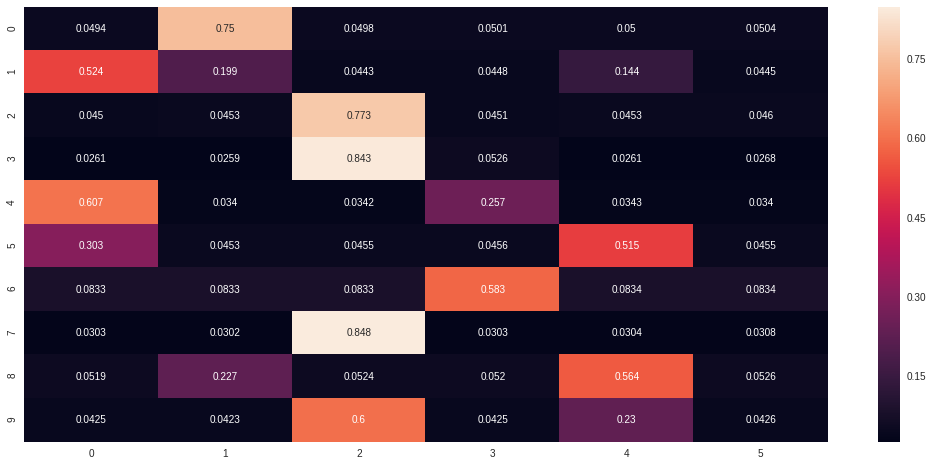

In [144]:
plt.figure(figsize=(18, 8))
sns.heatmap(topics_lda[0:10, :], annot=True,  fmt='.3')

In [145]:
train.iloc[:10, 2:]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,1,0,1,0,1,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,1,0,1,0,1,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


С некоторыми типами модель угадала. Качество получилось выше среднего:

In [146]:
preds = pd.DataFrame(topics_lda)

In [147]:
y_scores = preds.values
y_true = train.iloc[:, 2:].values

In [148]:
roc_auc_score(y_true, y_scores, average='micro')

0.6530376620635673

In [149]:
topics_words_lda = pd.DataFrame(lda.components_.T, index = tfidf_vectorizer.get_feature_names())

In [150]:
for i in range(6):
    print('Type', i)
    print(topics_words_lda[i].sort_values(ascending=False)[1:10], '\n')

Type 0
suck      415.226629
like      388.231417
shit      366.204033
know      320.085727
gay       317.393675
stupid    304.019337
hey       303.107672
bitch     276.847679
love      263.375447
Name: 0, dtype: float64 

Type 1
hi          261.131336
english     252.445477
barnstar    215.470507
language    213.994211
article     189.703312
say         173.971182
country     158.284819
know        157.148751
state       155.766788
Name: 1, dtype: float64 

Type 2
source     1118.287544
say         832.398863
use         757.067989
think       699.898363
make        682.013607
section     572.425330
like        570.755594
fact        510.596589
know        501.014723
Name: 2, dtype: float64 

Type 3
page         1236.844028
wikipedia    1023.577025
block        1004.146733
talk          811.252129
welcome       772.043160
thank         718.950331
stop          643.949577
vandalize     635.255407
vandalism     623.540350
Name: 3, dtype: float64 

Type 4
image     616.384415
block     59

Модель разлелила комментарии на темы, не учитывая эмоциональную окраску слов

## LSA

In [151]:
from sklearn.decomposition import TruncatedSVD

In [152]:
%%time
lsa = TruncatedSVD(n_components=6)
lsa.fit(dtm)

CPU times: user 736 ms, sys: 320 ms, total: 1.06 s
Wall time: 1.06 s


In [153]:
topics_lsa = lsa.transform(dtm)

In [154]:
topics_lsa.shape

(150000, 6)

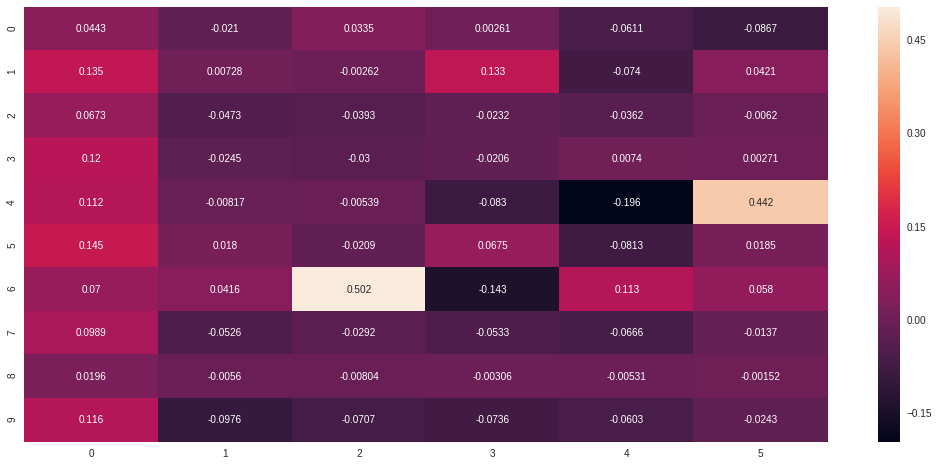

In [155]:
plt.figure(figsize=(18, 8))
sns.heatmap(topics_lsa[0:10, :], annot=True,  fmt='.3')

In [156]:
preds = pd.DataFrame(topics_lsa)

In [157]:
y_scores = preds.values
y_true = train.iloc[:, 2:].values

In [158]:
roc_auc_score(y_true, y_scores, average='micro')

0.5734862163344222

In [159]:
topics_words_lsa = pd.DataFrame(lsa.components_.T, index = tfidf_vectorizer.get_feature_names())

In [160]:
topics_words_lsa.shape

(11358, 6)

In [161]:
for i in range(6):
    print('Type %d'% i)
    print(topics_words_lsa[i].sort_values(ascending=False)[1:10], '\n')

Type 0
article      0.332832
edit         0.234975
wikipedia    0.217648
talk         0.209153
block        0.147156
use          0.138930
make         0.136828
like         0.132165
add          0.127537
Name: 0, dtype: float64 

Type 1
block        0.419102
vandalize    0.294564
continue     0.281183
page         0.232631
stop         0.170203
wikipedia    0.108295
talk         0.062950
vandalism    0.049783
user         0.049476
Name: 1, dtype: float64 

Type 2
wikipedia     0.402560
thank         0.260748
hello         0.223306
test          0.208401
experiment    0.172058
sandbox       0.169080
thanks        0.160701
use           0.147280
contribute    0.102412
Name: 2, dtype: float64 

Type 3
talk          0.525141
deletion      0.127501
delete        0.098040
speedy        0.084953
user          0.083511
tag           0.072280
comment       0.068818
thanks        0.067388
discussion    0.046200
Name: 3, dtype: float64 

Type 4
deletion     0.287453
wikipedia    0.209916
speedy 

### Векторизация с n-граммами

In [162]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, 
                                   min_df=0.0001,
                                   strip_accents='unicode', 
                                   stop_words='english',
                                   ngram_range=(1,3))

In [163]:
dtm = tfidf_vectorizer.fit_transform(new_data)
dtm

<150000x27362 sparse matrix of type '<class 'numpy.float64'>'
	with 3171100 stored elements in Compressed Sparse Row format>

In [164]:
%%time
lda = LatentDirichletAllocation(n_components=6)
lda.fit(dtm)

CPU times: user 3min 44s, sys: 88 ms, total: 3min 45s
Wall time: 3min 45s


In [165]:
topics_lda = lda.transform(dtm)

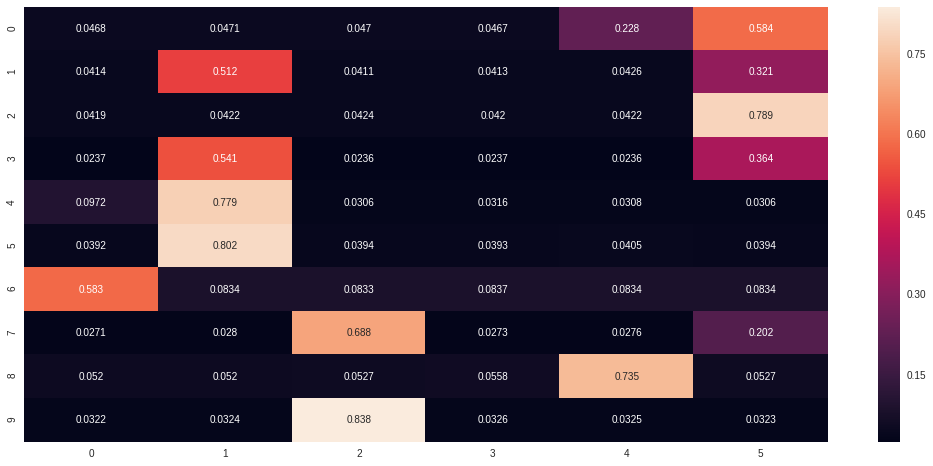

In [166]:
plt.figure(figsize=(18, 8))
sns.heatmap(topics_lda[0:10, :], annot=True,  fmt='.3')

In [167]:
preds = pd.DataFrame(topics_lda)

In [168]:
y_scores = preds.values
y_true = train.iloc[:, 2:].values

In [169]:
roc_auc_score(y_true, y_scores, average='micro')

0.5128322863304455

In [170]:
topics_words_lda = pd.DataFrame(lda.components_.T, index = tfidf_vectorizer.get_feature_names())
topics_words_lda[0].sort_values(ascending=False)[1:10]

welcome              377.724294
wikipedia            308.652074
hello                278.843120
welcome wikipedia    273.089744
delete               265.536945
speedy               259.018745
fuck                 254.283026
page                 249.469539
add                  240.987009
Name: 0, dtype: float64

In [171]:
%%time
lsa = TruncatedSVD(n_components=6)
lsa.fit(dtm)

CPU times: user 1.02 s, sys: 84 ms, total: 1.11 s
Wall time: 1.01 s


In [172]:
topics_lsa = lsa.transform(dtm)

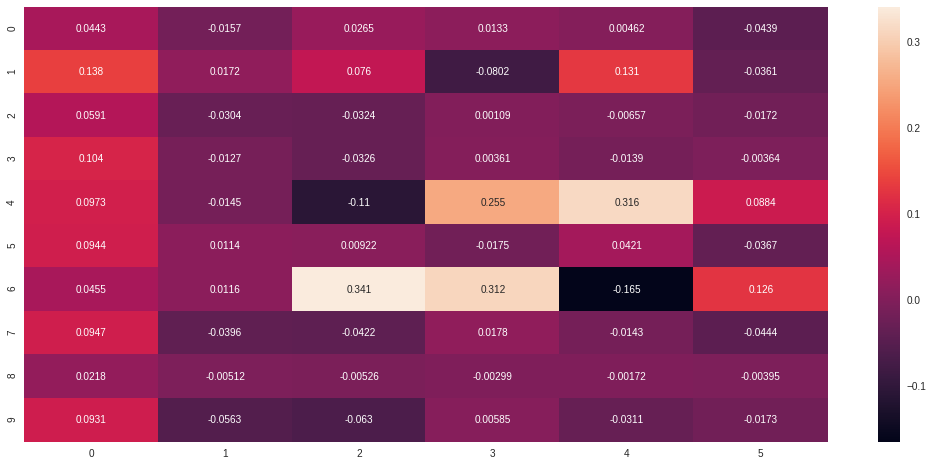

In [173]:
plt.figure(figsize=(18, 8))
sns.heatmap(topics_lsa[0:10, :], annot=True,  fmt='.3')

In [174]:
preds = pd.DataFrame(topics_lsa)

In [175]:
y_scores = preds.values
y_true = train.iloc[:, 2:].values

In [176]:
roc_auc_score(y_true, y_scores, average='micro')

0.6227921745486709

In [177]:
topics_words_lsa = pd.DataFrame(lsa.components_.T, index = tfidf_vectorizer.get_feature_names())
topics_words_lsa[0].sort_values(ascending=False)[1:10]

page         0.288374
edit         0.188186
talk         0.185768
wikipedia    0.173614
make         0.141556
like         0.136429
think        0.133287
use          0.131656
say          0.128741
Name: 0, dtype: float64

## Word2Vec

In [27]:
from gensim.utils import simple_preprocess
from gensim.models.word2vec import Word2Vec

C:\Users\admin\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [28]:
comment_tokens = []
for i in range(len(new_data)):
    tokens = simple_preprocess(new_data[i])
    comment_tokens.append(tokens)

In [29]:
w2v_model = Word2Vec(size=100, 
                     window=4,
                     sg=0, # cbow, 1 - skip gram
                     hs=0, # hierarchical softmax
                     negative=10, # число слов для которых обновлять веса
                     sample=0.001, # в вероятности 
                     alpha=0.025, # learing rate
                     min_alpha=0.0001, # до чего уменьшать lr
                     min_count=1, # слова которые встретились минимум два раза
                     workers=4)

In [30]:
w2v_model.build_vocab(sentences=comment_tokens)

In [31]:
len(w2v_model.wv.vocab)

161743

In [32]:
w2v_model.corpus_count

150000

In [33]:
%%time
w2v_model.train(comment_tokens, total_examples=w2v_model.corpus_count, epochs=100, compute_loss=True) 

Wall time: 14min 37s


(374579229, 393444400)

Посмотрим, насколько хорошо обучилась модель. Она выдает довольно правильные ответы

In [33]:
w2v_model.wv.most_similar(positive=['one', 'second'], negative=['two'], topn=10)

[('first', 0.6571258306503296),
 ('least', 0.5418002605438232),
 ('yet', 0.5396069288253784),
 ('third', 0.5122408270835876),
 ('even', 0.50956791639328),
 ('someone', 0.5076727271080017),
 ('since', 0.4843164384365082),
 ('say', 0.4765189588069916),
 ('think', 0.47448205947875977),
 ('either', 0.4717817008495331)]

In [34]:
w2v_model.wv.most_similar(positive=['message', 'receive'], negative=['send'], topn=10)

[('comment', 0.5731837749481201),
 ('response', 0.5477202534675598),
 ('note', 0.5268842577934265),
 ('barnstars', 0.49947449564933777),
 ('warning', 0.4725459814071655),
 ('reply', 0.45644867420196533),
 ('feedback', 0.44625648856163025),
 ('email', 0.4203319549560547),
 ('discussion', 0.39284586906433105),
 ('contributor', 0.3919331133365631)]

In [35]:
w2v_model.wv.similar_by_word("cat")

[('fowl', 0.4842471480369568),
 ('dog', 0.4784161448478699),
 ('klepto', 0.44821807742118835),
 ('rutan', 0.4244723320007324),
 ('genus', 0.4173891246318817),
 ('ness', 0.41194093227386475),
 ('zombies', 0.40990936756134033),
 ('puppy', 0.40797674655914307),
 ('shrimp', 0.40748006105422974),
 ('nondiffusing', 0.4063184857368469)]

In [36]:
w2v_model.wv.similar_by_word("wikipedia")

[('wiki', 0.856576681137085),
 ('wp', 0.801637589931488),
 ('encyclopedia', 0.6108202338218689),
 ('user', 0.5500448346138),
 ('allow', 0.5416158437728882),
 ('editor', 0.5264638066291809),
 ('policy', 0.5193881392478943),
 ('site', 0.5181913375854492),
 ('wish', 0.48319607973098755),
 ('encourage', 0.4823598265647888)]

In [34]:
size = 100

In [35]:
# функция для получения вектора комментария из векторов слов, входящих в него
def get_comment_vector(comment):
    vec = np.zeros((1, size))
    count = 0
    for word in comment:
        try:
            vec += w2v_model[word].reshape((1, size))
            count += 1
        except KeyError:
            continue
    if count!=0:
        vec /= count
    return vec

In [36]:
comment_vector = np.concatenate([get_comment_vector(comment) for comment in comment_tokens])

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [37]:
comment_vector.shape

(150000, 100)

In [ ]:
#w2v_model2 = Word2Vec(size=500, 
#                     window=4,
#                     sg=0, # cbow, 1 - skip gram
#                     hs=0, # hierarchical softmax
#                     negative=5, # число слов для которых обновлять веса
#                     sample=0.0001, # в вероятности 
#                     alpha=0.025, # learing rate
#                     min_alpha=0.0001, # до чего уменьшать lr
#                     min_count=2, # слова которые встретились минимум два раза
#                     workers=4)

In [ ]:
#w2v_model2.build_vocab(sentences=comment_tokens)

In [ ]:
#%%time
#w2v_model2.train(comment_tokens, total_examples=w2v_model.corpus_count, epochs=100, compute_loss=True) 

## Train test split

Попробуем сделать стратифицированные выборки

In [25]:
from sklearn.model_selection import train_test_split

In [141]:
Data = pd.DataFrame(comment_vector)
Data.shape

(150000, 100)

In [142]:
label = train.iloc[:,2:]
label.shape

(150000, 6)

In [157]:
train_data, test_data, train_labels, test_labels = train_test_split(Data, label, test_size=0.3, stratify=label)

## SVM

In [49]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
#clf = OneVsRestClassifier(SVC(С=0.1, kernel='linear', probability=True))

In [ ]:
#%%time
#clf.fit(train_data, train_labels)

In [ ]:
#pred_labels = pd.DataFrame(clf.predict_proba(test_data))

In [ ]:
#roc_auc_score(test_labels,pred_labels)

Считалось очень долго, даже на kaggle, так что пока оставим и попробуем другой алгоритм

## Logistic Regression

In [144]:
from sklearn.linear_model import LogisticRegressionCV

In [158]:
log_reg = OneVsRestClassifier(LogisticRegressionCV(cv=skf, multi_class='ovr'))

In [159]:
%%time
log_reg.fit(train_data, train_labels)

Wall time: 53.2 s


OneVsRestClassifier(estimator=LogisticRegressionCV(Cs=10, class_weight=None,
           cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0),
          n_jobs=None)

In [169]:
pred_labels = pd.DataFrame(log_reg.predict_proba(test_data))

In [171]:
roc_auc_score(test_labels,pred_labels)

0.9422161033632181

## CNN

In [54]:
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Input, Embedding, Conv1D, Conv2D, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, Flatten
from keras.optimizers import Adam, RMSprop

C:\Users\admin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Для того, чтобы представить комментарии в виде матриц для нейронной сети, необходимо задать максимальную длину комментария

In [55]:
len_comments = [] # список длин каждого комментария
for comment in comment_tokens:
    len_comments.append(len(comment))

In [56]:
len_comments = pd.Series(len_comments)

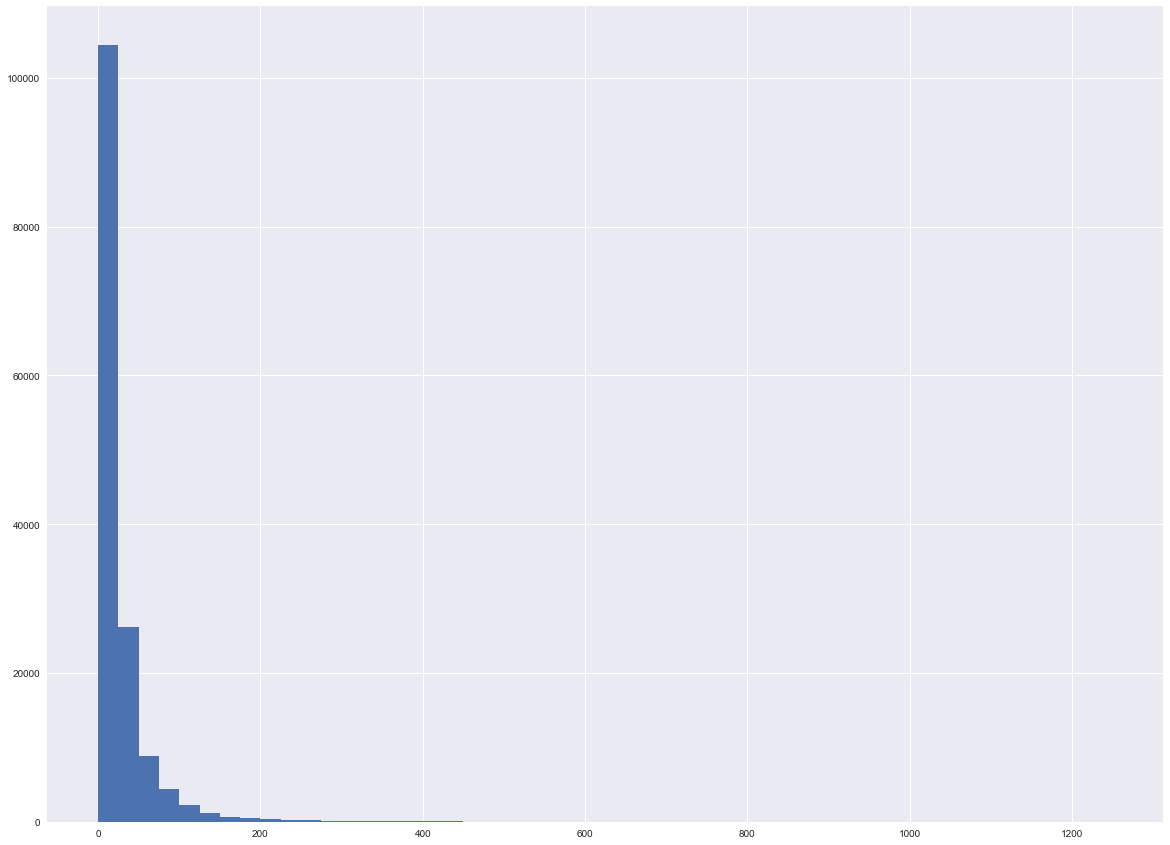

In [57]:
len_comments.hist(bins=50, figsize=(20,15))

Большинство комментариев имеют небольшую длину, близкую к 0

In [58]:
len_comments.quantile(q=0.95)

91.0

Значение 91 покрывает 95% процентов всех комментариев, значит ограничим максимальный размер вектора каждого комментария этим числом. Если количество слов в комментарии будет превышать это число, они отбросятся, недостающие слова заменятся нулями

In [60]:
len(len_comments[len_comments<92].index)

142617

In [ ]:
#idx = len_comments[len_comments<92].index - был вариант брать предложения только с меньшим количеством слов, 
                                            #чтобы не обрезать слова из длинных комментариев, но на результат это не повлияло

In [102]:
Data = new_data
label = train.iloc[:,2:].values

In [103]:
train_data,test_data,train_labels,test_labels = train_test_split(Data, label,test_size=0.05, stratify=label)

In [104]:
max_words = 161743 # размер словаря
max_len = 91 # максимальная длина комментария

Размер словаря намного превышает максимальную длину комментария. Так как мы хотим представить каждый комментарий в виде вектора длины 91, где каждый элемент(слово) будет соответствовать его номеру в словаре, то комментарии с разным набором слов будут заметно отличаться друг от друга. В задаче классификации по темам это могло бы быть полезно, посмотрим, как это повлияет на анализ токсичности

In [105]:
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(comment_tokens)

In [106]:
train_sequences = tok.texts_to_sequences(train_data)
train_sequences_matrix = sequence.pad_sequences(train_sequences,maxlen=max_len) 

test_sequences = tok.texts_to_sequences(test_data)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [107]:
train_sequences_matrix.shape

(142500, 91)

Создадим "веса" для слов для слоя Embedding, для этого возьмем векторные представления слов, полученные в модели word2vec

In [67]:
word_index = tok.word_index

In [244]:
word_index

{'article': 1,
 'page': 2,
 'wikipedia': 3,
 'would': 4,
 'use': 5,
 'one': 6,
 'make': 7,
 'like': 8,
 'please': 9,
 'say': 10,
 'think': 11,
 'edit': 12,
 'talk': 13,
 'see': 14,
 'source': 15,
 'know': 16,
 'get': 17,
 'go': 18,
 'also': 19,
 'add': 20,
 'people': 21,
 'time': 22,
 'good': 23,
 'need': 24,
 'take': 25,
 'may': 26,
 'remove': 27,
 'want': 28,
 'look': 29,
 'well': 30,
 'delete': 31,
 'link': 32,
 'find': 33,
 'block': 34,
 'even': 35,
 'work': 36,
 'fuck': 37,
 'could': 38,
 'name': 39,
 'change': 40,
 'thanks': 41,
 'user': 42,
 'section': 43,
 'give': 44,
 'way': 45,
 'information': 46,
 'point': 47,
 'comment': 48,
 'seem': 49,
 'try': 50,
 'list': 51,
 'thing': 52,
 'write': 53,
 'first': 54,
 'fact': 55,
 'editor': 56,
 'deletion': 57,
 'state': 58,
 'read': 59,
 'reference': 60,
 'new': 61,
 'right': 62,
 'much': 63,
 'many': 64,
 'image': 65,
 'ive': 66,
 'really': 67,
 'discussion': 68,
 'include': 69,
 'come': 70,
 'mean': 71,
 'since': 72,
 'revert': 73,
 '

In [68]:
len(word_index)

161743

In [69]:
len(w2v_model.wv.vocab)

161743

In [70]:
embeddings_index = {}
for word, index in word_index.items():
    embeddings_index[word] = w2v_model.wv[word]

In [71]:
embedding_matrix = np.zeros((max_words+1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [74]:
image_input = Input(shape=(max_len, ))
layer = Embedding(input_dim=max_words+1, output_dim=100, input_length=max_len, weights=[embedding_matrix])(image_input)
layer = Dropout(0.7) (layer)
layer = Conv1D(filters=100, kernel_size=3, activation='relu')(layer)
avg_pl = GlobalAveragePooling1D()(layer)
max_pl = GlobalMaxPooling1D()(layer)

conc = concatenate([avg_pl, max_pl])

layer = Dense(6, activation="sigmoid")(conc)
cnn_model = Model(inputs=image_input, outputs=layer)

In [75]:
cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [76]:
cnn_model.fit(train_sequences_matrix, train_labels, validation_split=0.05, epochs=10, batch_size=128)

Train on 135375 samples, validate on 7125 samples
Epoch 1/10
135375/135375 [==============================] - 524s 4ms/step - loss: 0.1124 - acc: 0.9652 - val_loss: 0.0812 - val_acc: 0.9731
Epoch 2/10
135375/135375 [==============================] - 521s 4ms/step - loss: 0.0816 - acc: 0.9729 - val_loss: 0.0834 - val_acc: 0.9729
Epoch 3/10
135375/135375 [==============================] - 520s 4ms/step - loss: 0.0766 - acc: 0.9741 - val_loss: 0.0770 - val_acc: 0.9743
Epoch 4/10
135375/135375 [==============================] - 544s 4ms/step - loss: 0.0737 - acc: 0.9748 - val_loss: 0.0883 - val_acc: 0.9720
Epoch 5/10
135375/135375 [==============================] - 535s 4ms/step - loss: 0.0718 - acc: 0.9753 - val_loss: 0.0683 - val_acc: 0.9762
Epoch 6/10
135375/135375 [==============================] - 535s 4ms/step - loss: 0.0701 - acc: 0.9758 - val_loss: 0.0747 - val_acc: 0.9751
Epoch 7/10
135375/135375 [==============================] - 523s 4ms/step - loss: 0.0691 - acc: 0.9759 - val_l

In [77]:
pred_labels = cnn_model.predict(test_sequences_matrix)

In [78]:
roc_auc_score(test_labels,pred_labels)

0.9688184679768416

In [79]:
final_test_sentences = tok.texts_to_sequences(new_test_data)
final_test_matrix = sequence.pad_sequences(final_test_sentences,maxlen=max_len)

In [80]:
pred_test = cnn_model.predict(final_test_matrix)

In [81]:
submission = pd.DataFrame({'id': test.id})

In [82]:
submission = submission.join(pd.DataFrame(data=pred_test, columns=train.columns.tolist()[2:]))

In [83]:
submission.to_csv('submission.csv', index=False)

In [84]:
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,150000,0.582710,0.007130,0.145887,0.002489,0.176508,0.013374
1,150001,0.015951,0.000367,0.004417,0.000210,0.006007,0.003361
2,150002,0.020151,0.000531,0.006888,0.000615,0.005150,0.001044
3,150003,0.006069,0.000346,0.004013,0.000447,0.002536,0.000715
4,150004,0.018623,0.000392,0.004656,0.000676,0.006703,0.001451


## LSTM

In [108]:
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, MaxPooling1D, BatchNormalization
from keras.optimizers import RMSprop

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [109]:
model = Sequential()
model.add(Embedding(input_dim=max_words+1, output_dim=100, input_length=max_len, weights=[embedding_matrix], trainable=True))
model.add(LSTM(60, return_sequences=True))

model.add(Conv1D(filters=128, kernel_size=5))
model.add(MaxPooling1D(pool_size=3))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))

In [110]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.001),metrics=['accuracy'])

In [111]:
model.fit(train_sequences_matrix,train_labels,batch_size=128,epochs=10,validation_split=0.05)

Train on 135375 samples, validate on 7125 samples
Epoch 1/10
135375/135375 [==============================] - 460s 3ms/step - loss: 0.0892 - acc: 0.9686 - val_loss: 0.0672 - val_acc: 0.9778
Epoch 2/10
135375/135375 [==============================] - 449s 3ms/step - loss: 0.0639 - acc: 0.9778 - val_loss: 0.0672 - val_acc: 0.9778
Epoch 3/10
135375/135375 [==============================] - 449s 3ms/step - loss: 0.0601 - acc: 0.9788 - val_loss: 0.0650 - val_acc: 0.9783
Epoch 4/10
135375/135375 [==============================] - 451s 3ms/step - loss: 0.0574 - acc: 0.9797 - val_loss: 0.0672 - val_acc: 0.9781
Epoch 5/10
135375/135375 [==============================] - 457s 3ms/step - loss: 0.0547 - acc: 0.9804 - val_loss: 0.0659 - val_acc: 0.9780
Epoch 6/10
135375/135375 [==============================] - 454s 3ms/step - loss: 0.0521 - acc: 0.9812 - val_loss: 0.0717 - val_acc: 0.9782
Epoch 7/10
135375/135375 [==============================] - 451s 3ms/step - loss: 0.0495 - acc: 0.9818 - val_l

In [112]:
pred_labels = model.predict(test_sequences_matrix)

In [113]:
roc_auc_score(test_labels,pred_labels)

0.9606481431176425

In [114]:
pred_test = model.predict(final_test_matrix)

In [115]:
submission = pd.DataFrame({'id': test.id})

In [116]:
submission = submission.join(pd.DataFrame(data=pred_test, columns=train.columns.tolist()[2:]))

In [117]:
submission.to_csv('submission.csv', index=False)

Модель немного переобучается, и ни одна из множества попыток с изменением параметра Dropout и learning rate не смогла это исправить(считала отдельно на kaggle, т.к. очень ресурсозатратно)

In [118]:
model = Sequential()
model.add(Embedding(max_words+1, 100, input_length=max_len,  weights=[embedding_matrix], trainable=True))
model.add(Dropout(0.6))
model.add(LSTM(60, return_sequences=True))

model.add(Conv1D(filters=128, kernel_size=5))
model.add(MaxPooling1D(pool_size=3))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(6, activation='sigmoid'))

In [119]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.001),metrics=['accuracy'])

In [120]:
model.fit(train_sequences_matrix,train_labels,batch_size=128,epochs=10,validation_split=0.05)

Train on 135375 samples, validate on 7125 samples
Epoch 1/10
135375/135375 [==============================] - 482s 4ms/step - loss: 0.1142 - acc: 0.9601 - val_loss: 0.0807 - val_acc: 0.9740
Epoch 2/10
135375/135375 [==============================] - 482s 4ms/step - loss: 0.0805 - acc: 0.9735 - val_loss: 0.0718 - val_acc: 0.9761
Epoch 3/10
135375/135375 [==============================] - 474s 4ms/step - loss: 0.0779 - acc: 0.9742 - val_loss: 0.0703 - val_acc: 0.9771
Epoch 4/10
135375/135375 [==============================] - 499s 4ms/step - loss: 0.0762 - acc: 0.9746 - val_loss: 0.0717 - val_acc: 0.9776
Epoch 5/10
135375/135375 [==============================] - 543s 4ms/step - loss: 0.0770 - acc: 0.9744 - val_loss: 0.0720 - val_acc: 0.9774
Epoch 6/10
135375/135375 [==============================] - 572s 4ms/step - loss: 0.0751 - acc: 0.9750 - val_loss: 0.0747 - val_acc: 0.9762
Epoch 7/10
135375/135375 [==============================] - 653s 5ms/step - loss: 0.0744 - acc: 0.9749 - val_l

In [121]:
pred_labels = model.predict(test_sequences_matrix)

In [122]:
roc_auc_score(test_labels,pred_labels)

0.9572563726772865